In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import sys
from IPython.display import display

In [3]:
def on_kaggle() -> bool:
    try:
        import gresearch_crypto
        return True
    except ModuleNotFoundError:
        return False

In [4]:
# HYPER PARAMETERS
ON_KAGGLE = on_kaggle()
SAMPLE_LEVEL = 1
USE_SAMPLE = SAMPLE_LEVEL == 1
USE_TOY_SAMPLE = SAMPLE_LEVEL == 2

FORCE_REWRITE = True or (ON_KAGGLE and SAMPLE_LEVEL == 0)

In [5]:
if not ON_KAGGLE and os.path.abspath('.').endswith('notebook'):
    os.chdir('../')

In [6]:
#IMPORT_SCRIPT!
# THIS CELL WILL BE REMOVE WITH SCRIPTS IN SRC
if './src/' not in sys.path:
    sys.path.append('./src/')

from preprocessing import *
from metrics import *
from cv import *
from tracking import *
import util

In [7]:
if ON_KAGGLE:
    RAW_DIR = Path('../input/g-research-crypto-forecasting/')
    SAMPLE_DIR = Path('../input/create-sample-dataset/data/raw/sample/')
    TOY_SAMPLE_DIR = Path('../input/create-sample-dataset/data/raw/toy_sample/')
else:
    RAW_DIR =  Path('data/raw')
    TOY_SAMPLE_DIR = RAW_DIR.joinpath('toy_sample')
    SAMPLE_DIR = RAW_DIR.joinpath('sample')

# filename
TRAIN_FILE = 'train.csv'
ASSET_DETAILS_PATH = RAW_DIR / 'asset_details.csv'

In [8]:
if USE_TOY_SAMPLE:
    print('USING TOY DATASET')
    RAW_TRAIN_PATH = TOY_SAMPLE_DIR / TRAIN_FILE

elif USE_SAMPLE:
    print('USING SAMPLE DATASET')
    RAW_TRAIN_PATH = SAMPLE_DIR / TRAIN_FILE

else:
    print('USING RAW DATASET')
    RAW_TRAIN_PATH = RAW_DIR / TRAIN_FILE

assert RAW_TRAIN_PATH.exists()

USING SAMPLE DATASET


In [9]:
!ls {RAW_DIR}

asset_details.csv		   sample
example_sample_submission.csv	   supplemental_train.csv
example_test.csv		   toy_sample
g-research-crypto-forecasting.zip  train.csv
gresearch_crypto


In [10]:
%%time 
raw_df = pd.read_csv(RAW_TRAIN_PATH)

CPU times: user 7.93 s, sys: 679 ms, total: 8.6 s
Wall time: 8.6 s


In [11]:
from preprocessing.ingest_data import infer_dtypes, ingest_data


In [12]:
raw_df = ingest_data(raw_df, asset_details_path=ASSET_DETAILS_PATH)

In [13]:
raw_df.sort_values(by=['Asset_ID', 'time'], inplace=True)
raw_df.reset_index(drop=True, inplace=True)

In [14]:
raw_df.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,Asset_Name,time
0,1609459260,0,219.0,37.384998,37.422100,37.348701,37.389000,2749.5692,37.387058,-0.001669,Binance Coin,2021-01-01 00:01:00
1,1609459320,0,133.0,37.390499,37.402000,37.329800,37.331299,778.8680,37.351677,-0.001542,Binance Coin,2021-01-01 00:02:00
2,1609459380,0,151.0,37.317051,37.336700,37.272900,37.291500,890.9210,37.301258,-0.001028,Binance Coin,2021-01-01 00:03:00
3,1609459440,0,123.0,37.299149,37.323002,37.250198,37.291901,489.9361,37.297272,0.000174,Binance Coin,2021-01-01 00:04:00
4,1609459500,0,623.0,37.212799,37.285000,37.104801,37.213001,15144.3836,37.184082,0.000950,Binance Coin,2021-01-01 00:05:00


In [15]:
TARGET = 'Target'
INDEX_COLS = ['Asset_ID', 'Asset_Name', 'time', 'timestamp']

In [16]:
def compute_features(raw_df: pd.DataFrame) -> pd.DataFrame:
    df = raw_df.copy()
    df['upper_shadow'] = df['High'] - np.maximum(df['Close'], df['Open'])
    df['lower_shador'] = np.minimum(df['Close'], df['Open']) - df['Low']
    return df

In [17]:
feature_data = compute_features(raw_df)

In [18]:
feature_data = feature_data.dropna(subset=[TARGET]).reset_index(drop=True)

In [19]:
feature_data.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,Asset_Name,time,upper_shadow,lower_shador
0,1609459260,0,219.0,37.384998,37.422100,37.348701,37.389000,2749.5692,37.387058,-0.001669,Binance Coin,2021-01-01 00:01:00,0.033100,0.036297
1,1609459320,0,133.0,37.390499,37.402000,37.329800,37.331299,778.8680,37.351677,-0.001542,Binance Coin,2021-01-01 00:02:00,0.011501,0.001499
2,1609459380,0,151.0,37.317051,37.336700,37.272900,37.291500,890.9210,37.301258,-0.001028,Binance Coin,2021-01-01 00:03:00,0.019650,0.018600
3,1609459440,0,123.0,37.299149,37.323002,37.250198,37.291901,489.9361,37.297272,0.000174,Binance Coin,2021-01-01 00:04:00,0.023853,0.041702
4,1609459500,0,623.0,37.212799,37.285000,37.104801,37.213001,15144.3836,37.184082,0.000950,Binance Coin,2021-01-01 00:05:00,0.071999,0.107998


In [20]:
feature_data.tail()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,Asset_Name,time,upper_shadow,lower_shador
5298791,1632181200,13,986.0,0.090885,0.091054,0.090710,0.090941,5.734456e+06,0.090831,0.000199,TRON,2021-09-20 23:40:00,0.000113,0.000175
5298792,1632181260,13,715.0,0.091010,0.091277,0.090980,0.091203,1.989048e+06,0.091125,-0.003477,TRON,2021-09-20 23:41:00,0.000074,0.000030
5298793,1632181320,13,527.0,0.091171,0.091295,0.091092,0.091180,2.386078e+06,0.091185,-0.002437,TRON,2021-09-20 23:42:00,0.000115,0.000079
5298794,1632181380,13,463.0,0.091206,0.091290,0.091028,0.091081,1.568854e+06,0.091131,0.004843,TRON,2021-09-20 23:43:00,0.000084,0.000053
5298795,1632181440,13,512.0,0.090989,0.091133,0.090831,0.090885,1.900695e+06,0.090943,0.004163,TRON,2021-09-20 23:44:00,0.000144,0.000054


In [21]:
PULIC_LB_RANGE = ['2021-06-13 00:00:00',
                  '2021-09-13 00:00:00'] # 3 MONTH WORTH OF DATA

if USE_TOY_SAMPLE:
    EVAL_PERIODS = [['2021-09-15', '2021-09-22']]

elif USE_SAMPLE:
    EVAL_PERIODS = [PULIC_LB_RANGE]
    
else:
    EVAL_PERIODS = [['2019-01-01', '2019-04-01'],
                    ['2021-03-13', '2021-06-12 00:00:00'], 
                    PULIC_LB_RANGE]

In [22]:
COLUMNS_TO_DROP = [TARGET, 'Asset_Name', 'time', 'timestamp', 'Asset_ID']
FEATURES = feature_data.columns.drop(COLUMNS_TO_DROP)
OUTPUT_PATH = Path('artifacts/baseline/')
if SAMPLE_LEVEL > 0:
    OUTPUT_PATH = OUTPUT_PATH / f'sample/{SAMPLE_LEVEL}'
OUTPUT_PATH.mkdir(exist_ok=True, parents=True)

In [23]:
MODEL_PARAMS = util.load_config('conf/model/xgboost/base.yml')

In [24]:
MODEL_PARAMS

{'n_estimators': 500,
 'max_depth': 11,
 'learning_rate': 0.05,
 'subsample': 0.9,
 'colsample_bytree': 0.7,
 'tree_method': 'hist',
 'missing': -999,
 'random_state': 2020}

In [25]:
FEATURES

Index(['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP',
       'upper_shadow', 'lower_shador'],
      dtype='object')

In [26]:
from xgboost import XGBRegressor
import joblib

In [27]:
def train_crypto_model(train_data: pd.DataFrame,
                       valid_data: pd.DataFrame,
                       output_model_dir: str):
    CRYPTO_MODELS = {}
    output_model_dir = Path(output_model_dir)
    valid_yhat = np.zeros(len(valid_data))
    for crypto, train_crypto in train_data.groupby(by=['Asset_Name']):
        output_model_path = output_model_dir / f'{crypto}.pkl'
        print(f'{crypto}')
        if output_model_path.exists() and (not FORCE_REWRITE):
            print('importaning model')
            model = joblib.load(output_model_path)
        else:
            print('training model')
            model = XGBRegressor(**MODEL_PARAMS)
            model.fit(train_crypto[FEATURES], train_crypto[TARGET])
            joblib.dump(model, output_model_path)
        CRYPTO_MODELS[crypto] = model
        crypto_index = valid_data['Asset_Name'] == crypto
        valid_yhat[crypto_index] = model.predict(valid_data.loc[crypto_index, FEATURES])
    return CRYPTO_MODELS, valid_yhat

In [28]:
def filter_by_index(df: pd.DataFrame, index) -> pd.DataFrame:
    return df.loc[index, :].reset_index(drop=True)

In [31]:
CV = TimeSeriesSplit(EVAL_PERIODS, gap_unit='min', dt_col='time')
SCORES = []
valid_corrs = pd.DataFrame()
for fold, (train_idx, valid_idx) in enumerate(CV.split(feature_data)):
    train_data = filter_by_index(feature_data, train_idx)
    valid_data = filter_by_index(feature_data, valid_idx)
    print(train_data['time'].agg(('min', 'max')))

    print(valid_data['time'].agg(('min', 'max')))
    CRYPTO_MODELS, valid_yhat = train_crypto_model(train_data, valid_data,
                                                   output_model_dir=OUTPUT_PATH)
    
    valid_data['yhat'] = valid_yhat

    scores, fold_valid_corrs = compute_metrics(valid_data)
    scores['fold'] = fold
    valid_corrs = valid_corrs.append(fold_valid_corrs.assign(fold=fold), ignore_index=True)
    
    SCORES.append(scores)
    
cv_scores = pd.DataFrame(SCORES)

min   2021-01-01 00:01:00
max   2021-06-12 23:59:00
Name: time, dtype: datetime64[ns]
min   2021-06-13
max   2021-09-13
Name: time, dtype: datetime64[ns]
Binance Coin
training model
Bitcoin
training model
Bitcoin Cash
training model
Cardano
training model
Dogecoin
training model
EOS.IO
training model
Ethereum
training model
Ethereum Classic
training model
IOTA
training model
Litecoin
training model
Maker
training model
Monero
training model
Stellar
training model
TRON
training model


In [32]:
cv_scores

,theor_corr,weighted_corr,corr_min,corr_max,corr_std,fold
0,0.005335,0.001383,-0.024652,0.028,0.012643,0.0


In [33]:
cv_scores.mean()

theor_corr       0.005335
weighted_corr    0.001383
corr_min        -0.024652
corr_max         0.028000
corr_std         0.012643
fold             0.000000
dtype: float64

weighted_corr    0.005402
theor_corr       0.004504
corr_min        -0.022491
corr_max         0.020216
corr_std         0.011816
fold             0.000000

In [34]:
valid_corrs

,Asset_Name,corr,weight,weighted_corr,fold
0,Binance Coin,-0.002984,4.304065,-0.012841,0
1,Bitcoin,-0.006690,6.779922,-0.045360,0
2,Bitcoin Cash,-0.024652,2.397895,-0.059112,0
3,Cardano,0.007612,4.406719,0.033543,0
4,Dogecoin,0.010754,3.555348,0.038233,0
5,EOS.IO,0.001879,1.386294,0.002605,0
6,Ethereum,0.001303,5.894403,0.007680,0
7,Ethereum Classic,0.017444,2.079442,0.036273,0
8,IOTA,0.003723,1.098612,0.004090,0
9,Litecoin,0.006705,2.397895,0.016079,0


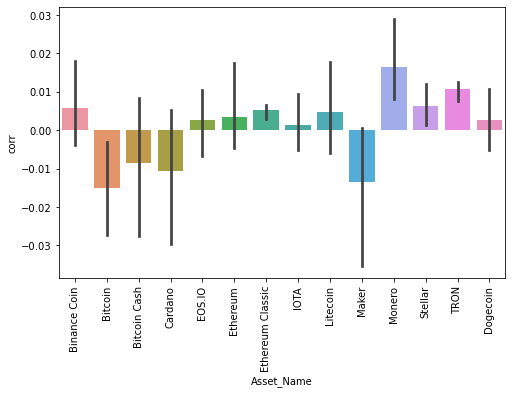

In [31]:
plt.figure(figsize=(8, 5))
sns.barplot(x='Asset_Name', y='corr', data=valid_corrs)
plt.xticks(rotation=90);

In [32]:
fi = pd.concat([pd.DataFrame({'feature': FEATURES,
                              'importance': model.feature_importances_,
                              'crypto': crypto})
                for crypto, model in CRYPTO_MODELS.items()])

In [33]:
fi_stats = fi.groupby('feature').describe().sort_values(('importance', 'mean'), ascending=False)

In [34]:
fi_stats

importance                                                    \
                  count      mean       std       min       25%       50%   
feature                                                                     
VWAP               14.0  0.138886  0.007907  0.123941  0.134401  0.140467   
Close              14.0  0.127674  0.009724  0.108362  0.122387  0.127368   
Low                14.0  0.125000  0.010152  0.108856  0.119553  0.125175   
High               14.0  0.117954  0.007846  0.106020  0.115104  0.116614   
lower_shador       14.0  0.104643  0.018171  0.054860  0.100117  0.105670   
upper_shadow       14.0  0.100381  0.017281  0.050835  0.098872  0.100959   
Open               14.0  0.099647  0.006382  0.088564  0.097126  0.099969   
Volume             14.0  0.093456  0.012518  0.077855  0.083761  0.089534   
Count              14.0  0.092359  0.007606  0.082910  0.087369  0.089532   

                                  
                   75%       max  
feature                           
VWAP          0.143636  0.148870  
Close         0.133239  0.146631  
Low           0.129925  0.147854  
High          0.123069  0.134034  
lower_shador  0.111020  0.130897  
upper_shadow  0.107076  0.122030  
Open          0.102350  0.114775  
Volume        0.103775  0.121276  
Count         0.094851  0.106558

<AxesSubplot:xlabel='importance', ylabel='feature'>

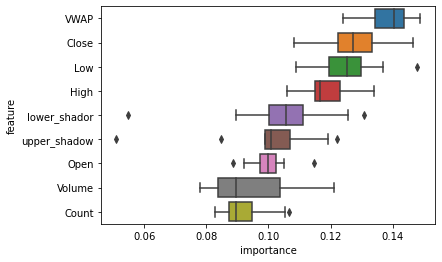

In [35]:
sns.boxplot(x='importance', y='feature',
            data=fi,
            order=fi_stats.index)

In [36]:
fi_crypto_table = fi.pivot('feature', 'crypto', 'importance')
fi_crypto_table.style.background_gradient(cmap="viridis", axis=1)


crypto,Binance Coin,Bitcoin,Bitcoin Cash,Cardano,Dogecoin,EOS.IO,Ethereum,Ethereum Classic,IOTA,Litecoin,Maker,Monero,Stellar,TRON
feature,,,,,,,,,,,,,,
Close,0.134420,0.125642,0.146631,0.126181,0.121596,0.124760,0.128555,0.118793,0.108362,0.130489,0.131786,0.116895,0.139606,0.133723
Count,0.089961,0.089676,0.095575,0.089388,0.092681,0.088964,0.087324,0.106558,0.103853,0.086146,0.087091,0.105398,0.082910,0.087503
High,0.126728,0.119548,0.134034,0.123587,0.108124,0.114958,0.115859,0.121513,0.107482,0.116986,0.116243,0.106020,0.124732,0.115542
Low,0.119440,0.130538,0.147854,0.130868,0.118741,0.123087,0.125496,0.128087,0.108856,0.124855,0.119891,0.109608,0.137037,0.125646
Open,0.102243,0.103726,0.114775,0.100680,0.092875,0.100502,0.104896,0.097058,0.088564,0.102386,0.098591,0.092001,0.097329,0.099436
VWAP,0.146299,0.140248,0.148870,0.134937,0.140462,0.134222,0.143683,0.132534,0.123941,0.147946,0.143495,0.124455,0.140473,0.142837
Volume,0.082795,0.082996,0.106566,0.086056,0.080774,0.097055,0.093681,0.121276,0.106015,0.087988,0.091079,0.106508,0.077855,0.087744
lower_shador,0.099354,0.105800,0.054860,0.105539,0.125609,0.107940,0.099856,0.089613,0.130897,0.101936,0.111762,0.122139,0.100897,0.108794
upper_shadow,0.098760,0.101826,0.050835,0.102764,0.119138,0.108513,0.100650,0.084567,0.122030,0.101269,0.100061,0.116977,0.099161,0.098776


In [38]:
if SAMPLE_LEVEL == 0:
    scores_mean = cv_scores.mean().to_dict()
    valid_corrs.to_csv(OUTPUT_PATH / 'corrs.csv', index=False)

    cv_scores.to_csv(OUTPUT_PATH / 'cv_scores.csv', index=False)

    _config = {'model': MODEL_PARAMS}
    track_experiment('model-per-crypto', mlflow_experiment='leaderboard',
                     config=_config,
                     scores=scores_mean, artifacts_dir=str(OUTPUT_PATH))